# DATA PRE-PROCESSING

In [208]:
from functools import reduce
import glob
import pandas as pd
import numpy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from pyspc import *
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from pmdarima.arima import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import chi2_contingency
from sklearn import preprocessing

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [209]:
data = pd.read_csv('data/aqi_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
print(data.dtypes)
data.head()

State Name                     object
State Code                      int64
Date                   datetime64[ns]
Sum sites reporting             int64
AQI                             int64
Category                       object
OZ_AQI                        float64
SO_AQI                        float64
NO_AQI                        float64
CO_AQI                        float64
PM25_AQI                      float64
PM10_AQI                      float64
Temp                          float64
Wind Dir                      float64
Wind Speed                    float64
Year                            int64
Month                           int64
Day                             int64
dtype: object


,State Name,State Code,Date,Sum sites reporting,AQI,Category,OZ_AQI,SO_AQI,NO_AQI,CO_AQI,PM25_AQI,PM10_AQI,Temp,Wind Dir,Wind Speed,Year,Month,Day
0,Alabama,1,2017-04-23,28,33,Good,33.0,33.0,4.0,3.0,10.0,13.0,60.043055,255.861111,4.825000,2017,4,23
1,Alabama,1,2017-04-25,38,74,Moderate,74.0,56.0,22.0,7.0,35.0,19.0,67.054167,177.388889,2.137500,2017,4,25
2,Alabama,1,2017-05-01,38,67,Moderate,67.0,51.0,11.0,5.0,23.0,15.0,67.559722,224.250000,4.462500,2017,5,1
3,Alabama,1,2017-05-04,36,47,Good,46.0,43.0,12.0,5.0,30.0,10.0,61.244444,194.722222,5.484722,2017,5,4
4,Alabama,1,2017-05-05,29,47,Good,47.0,47.0,18.0,5.0,10.0,10.0,52.045833,243.125000,4.652778,2017,5,5


In [210]:
data.describe()

,State Code,Sum sites reporting,AQI,OZ_AQI,SO_AQI,NO_AQI,CO_AQI,PM25_AQI,PM10_AQI,Temp,Wind Dir,Wind Speed,Year,Month,Day
count,91851.000000,91851.000000,91851.000000,91818.000000,91340.000000,87028.000000,91134.000000,90312.000000,77651.000000,90762.000000,90787.000000,90786.000000,91851.000000,91851.000000,91851.000000
mean,28.828929,37.896027,63.994186,47.835403,16.796869,25.482442,6.273948,46.129086,28.345675,55.676341,187.866900,4.258130,2017.972967,6.519276,15.732665
std,15.793479,36.857979,56.523495,24.188416,29.153297,12.870148,4.666566,23.319050,55.783957,18.985975,55.221874,3.699658,1.413189,3.448870,8.801642
min,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-35.641288,10.541667,0.062500,2016.000000,1.000000,1.000000
25%,16.000000,15.000000,44.000000,34.000000,1.000000,16.000000,3.000000,31.000000,14.000000,41.710742,156.158703,2.700372,2017.000000,4.000000,8.000000
50%,29.000000,28.000000,54.000000,42.000000,6.000000,25.000000,6.000000,43.000000,21.000000,57.970535,189.968750,3.808399,2018.000000,7.000000,16.000000
75%,42.000000,46.000000,71.000000,50.000000,19.000000,33.000000,8.000000,56.000000,33.000000,71.269263,222.726389,5.249724,2019.000000,10.000000,23.000000
max,72.000000,265.000000,6403.000000,282.000000,200.000000,133.000000,181.000000,714.000000,6403.000000,97.612500,349.500000,406.185227,2020.000000,12.000000,31.000000


In [211]:
data.columns

Index(['State Name', 'State Code', 'Date', 'Sum sites reporting', 'AQI',
       'Category', 'OZ_AQI', 'SO_AQI', 'NO_AQI', 'CO_AQI', 'PM25_AQI',
       'PM10_AQI', 'Temp', 'Wind Dir', 'Wind Speed', 'Year', 'Month', 'Day'],
      dtype='object')

In [212]:
pollutants_list = ['OZ_AQI', 'SO_AQI', 'NO_AQI', 'CO_AQI', 'PM25_AQI','PM10_AQI']
other_factors = ['Temp', 'Wind Dir', 'Wind Speed']

# Outlier detection

### Univariate analysis

In [213]:
# # ZSCORE
# plt.hist(data['OZ_AQI'], bins=20, width=0.8)
# plt.xlabel('OZ_AQI')
# plt.ylabel('Count')
# plt.show()

# data['zscore'] = ( data.OZ_AQI - data.OZ_AQI.mean() ) / data.OZ_AQI.std()

In [214]:
# # ZSCORE MODIFIED
# median = numpy.nanmedian(data['OZ_AQI'])
# deviation_from_med = numpy.array(data['OZ_AQI'] - median)

# mad = numpy.nanmedian(numpy.abs(deviation_from_med))
# # mod_zscore = deviation_from_med/(1.4826 * mad)

# data['mod_zscore'] = deviation_from_med/(0.6745 * mad)
# data[(data['mod_zscore'] > 3.5) | (data['mod_zscore'] < -3.5)].shape

## ZSCORE AND ZSCORE MODIFIED ARE NOT USEFUL FOR THE TYPE OF DATA WE HAVE, A TIME SERIES DATA

In [215]:
# # Individual Charts
# pollutants_list = ['OZ_AQI', 'SO_AQI', 'NO_AQI', 'CO_AQI', 'PM25_AQI','PM10_AQI']

# for pollutant in pollutants_list:
#     x=numpy.array(data.index.tolist())
#     y1=numpy.array(data[pollutant])
#     f = plt.figure()

#     ax = f.add_subplot(111)

#     plt.plot(x, y1)
# #     plt.plot(x, y1[y1 <= 500])
#     plt.axhline(y=data[pollutant].mean())
#     plt.axhline(y=data[pollutant].mean()+3*data[pollutant].std(),color='r')
#     plt.axhline(y=data[pollutant].mean()-3*data[pollutant].std(),color='r')

#     plt.title('Individual Chart for: '+pollutant, fontsize=8)

#     plt.show()

### KNN for outlier detection

In [216]:
def knn_model(data,pollutant,n_neighbors):
    data_to_predict = data[pollutant].dropna().to_numpy().reshape(-1, 1)
    # data_to_predict = data[data['State Name'] == 'California'][pollutant].dropna().to_numpy().reshape(-1, 1)
    nbrs = NearestNeighbors(n_neighbors = 3)
    nbrs.fit(data_to_predict)
    # distances and indexes of k-neaighbors from model outputs
    distances, indexes = nbrs.kneighbors(data_to_predict)
    # plot mean of k-distances of each observation
    plt.plot(distances.mean(axis =1))
    plt.show()
    return distances

def plot_outliers(data,pollutant,threshold):
    outlier_index = numpy.where(distances.mean(axis = 1) > threshold)
    outlier_values = data[data[pollutant].notnull()].iloc[outlier_index]
     # plot data
    plt.scatter(data[data[pollutant].notnull()]["Date"], data[data[pollutant].notnull()][pollutant], color = "black", s = 65)
    # # plt.scatter(data[(data['State Name'] == 'California') & (data[pollutant].notnull())]["Date"],\
    # #             data[(data['State Name'] == 'California') & (data[pollutant].notnull())][pollutant], color = "black", s = 65)

    # # plot outlier values
    plt.scatter(outlier_values["Date"], outlier_values[pollutant], color = "r")
    print(f'Number of outliers in pollutant {pollutant} is:{len(outlier_values)}')

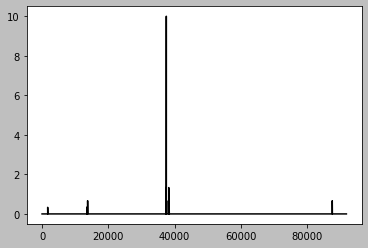

Number of outliers in pollutant OZ_AQI is:15


,State Name,State Code,Date,Sum sites reporting,AQI,Category,OZ_AQI,SO_AQI,NO_AQI,CO_AQI,PM25_AQI,PM10_AQI,Temp,Wind Dir,Wind Speed,Year,Month,Day
13764,Oregon,41,2017-12-21,44,86,Moderate,2.0,NaN,26.0,13.0,76.0,31.0,28.782458,186.613406,2.005396,2017,12,21
37421,Arizona,4,2020-03-26,77,274,Very Unhealthy,226.0,1.0,25.0,7.0,23.0,31.0,58.794643,241.796429,4.912262,2020,3,26
37454,Arizona,4,2020-04-28,78,240,Very Unhealthy,240.0,51.0,49.0,8.0,68.0,61.0,77.306677,193.005142,3.049539,2020,4,28
37496,Arizona,4,2020-07-29,83,228,Very Unhealthy,228.0,51.0,35.0,6.0,99.0,93.0,91.980202,229.588095,4.148312,2020,7,29
37497,Arizona,4,2020-07-30,74,232,Very Unhealthy,232.0,24.0,35.0,8.0,37.0,67.0,93.062500,237.039286,4.536905,2020,7,30
37516,Arizona,4,2020-08-19,85,282,Very Unhealthy,282.0,14.0,53.0,7.0,73.0,74.0,92.773809,192.218137,3.238214,2020,8,19
37520,Arizona,4,2020-08-23,78,224,Very Unhealthy,224.0,72.0,28.0,7.0,62.0,59.0,89.877976,189.991253,2.883659,2020,8,23
37521,Arizona,4,2020-08-24,78,272,Very Unhealthy,272.0,34.0,47.0,10.0,80.0,86.0,90.940476,161.465580,3.268432,2020,8,24
37522,Arizona,4,2020-08-25,86,262,Very Unhealthy,262.0,16.0,44.0,10.0,115.0,102.0,91.187500,154.525000,3.194762,2020,8,25
37523,Arizona,4,2020-08-26,78,247,Very Unhealthy,247.0,9.0,40.0,9.0,104.0,86.0,88.696429,166.379762,3.083214,2020,8,26


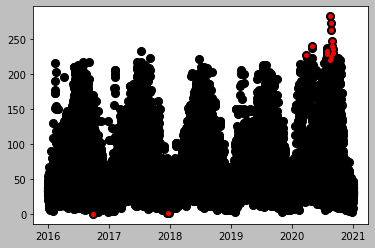

In [217]:
distances = knn_model(data,'OZ_AQI',3)
threshold = 0.5
plot_outliers(data,'OZ_AQI',threshold)

# GET OUTLIERS ROWS
oz_outlier_index = numpy.where(distances.mean(axis = 1) > threshold)
data[data['OZ_AQI'].notnull()].iloc[oz_outlier_index]

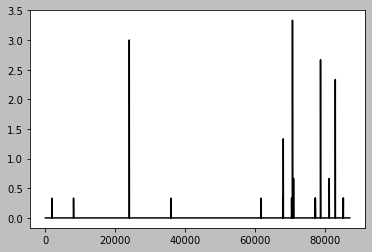

Number of outliers in pollutant NO_AQI is:6


,State Name,State Code,Date,Sum sites reporting,AQI,Category,OZ_AQI,SO_AQI,NO_AQI,CO_AQI,PM25_AQI,PM10_AQI,Temp,Wind Dir,Wind Speed,Year,Month,Day
25269,Louisiana,22,2019-12-22,31,42,Good,36.0,31.0,133.0,2.0,21.0,15.0,50.919444,252.666667,5.166666,2019,12,22
71829,Washington,53,2018-04-23,73,125,Unhealthy for Sensitive Groups,77.0,24.0,125.0,6.0,35.0,22.0,53.837719,162.984375,4.557812,2018,4,23
74790,California,6,2016-09-13,228,115,Unhealthy for Sensitive Groups,67.0,4.0,115.0,9.0,70.0,113.0,62.519976,206.212068,4.172393,2016,9,13
74791,California,6,2016-09-14,229,122,Unhealthy for Sensitive Groups,80.0,9.0,122.0,10.0,67.0,73.0,64.249310,201.287734,3.238653,2016,9,14
82880,Montana,30,2016-11-01,23,132,Unhealthy for Sensitive Groups,37.0,11.0,132.0,3.0,31.0,21.0,46.465909,200.312500,2.185417,2016,11,1
87484,Puerto Rico,72,2016-07-06,9,119,Unhealthy for Sensitive Groups,10.0,10.0,119.0,52.0,NaN,43.0,84.641667,76.791667,2.729167,2016,7,6


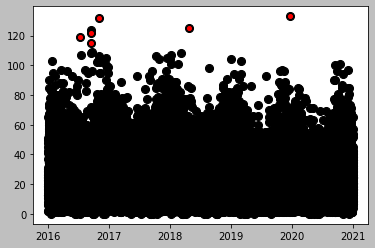

In [218]:
distances = knn_model(data,'NO_AQI',3)
threshold = 1
plot_outliers(data,'NO_AQI',threshold)

# GET OUTLIERS ROWS
no_outlier_index = numpy.where(distances.mean(axis = 1) > threshold)
data[data['NO_AQI'].notnull()].iloc[no_outlier_index]

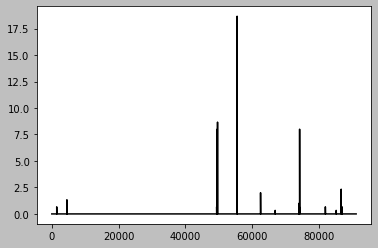

Number of outliers in pollutant CO_AQI is:6


,State Name,State Code,Date,Sum sites reporting,AQI,Category,OZ_AQI,SO_AQI,NO_AQI,CO_AQI,PM25_AQI,PM10_AQI,Temp,Wind Dir,Wind Speed,Year,Month,Day
49905,Oregon,41,2020-09-12,43,679,Hazardous,NaN,1.0,22.0,156.0,561.0,679.0,58.131410,193.360294,1.448684,2020,9,12
50003,Oregon,41,2020-09-14,38,456,Hazardous,44.0,1.0,26.0,181.0,331.0,341.0,61.881410,192.069692,1.717105,2020,9,14
50015,Oregon,41,2020-09-13,35,548,Hazardous,28.0,1.0,17.0,180.0,418.0,483.0,58.852564,193.792674,1.529605,2020,9,13
55943,California,6,2018-11-09,216,330,Hazardous,77.0,9.0,73.0,156.0,314.0,188.0,56.609037,167.133374,4.124421,2018,11,9
55944,California,6,2018-11-10,246,296,Very Unhealthy,58.0,14.0,51.0,125.0,248.0,161.0,53.501246,181.826465,2.708270,2018,11,10
74812,California,6,2016-06-16,229,315,Hazardous,115.0,4.0,45.0,100.0,80.0,315.0,65.577416,209.505701,4.313418,2016,6,16


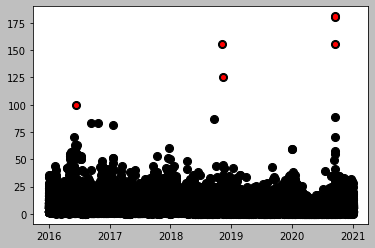

In [219]:
distances = knn_model(data,'CO_AQI',3)
threshold = 5
plot_outliers(data,'CO_AQI',threshold)

# GET OUTLIERS ROWS
co_outlier_index = numpy.where(distances.mean(axis = 1) > threshold)
data[data['CO_AQI'].notnull()].iloc[co_outlier_index]

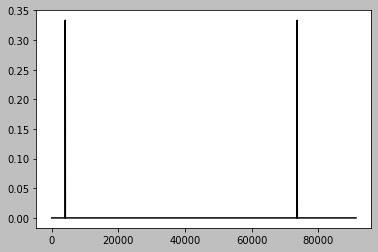

Number of outliers in pollutant SO_AQI is:2


,State Name,State Code,Date,Sum sites reporting,AQI,Category,OZ_AQI,SO_AQI,NO_AQI,CO_AQI,PM25_AQI,PM10_AQI,Temp,Wind Dir,Wind Speed,Year,Month,Day


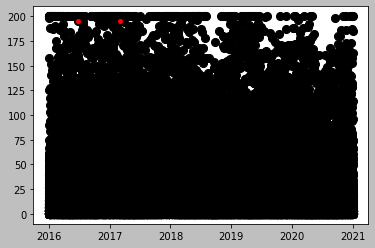

In [220]:
distances = knn_model(data,'SO_AQI',3)
threshold = 5
plot_outliers(data,'SO_AQI',0)

# GET OUTLIERS ROWS
so_outlier_index = numpy.where(distances.mean(axis = 1) > threshold)
data[data['SO_AQI'].notnull()].iloc[so_outlier_index]

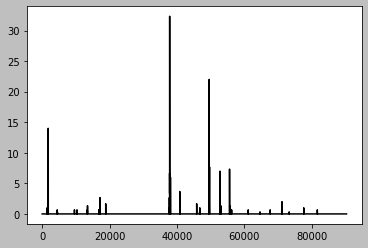

Number of outliers in pollutant PM25_AQI is:31


,State Name,State Code,Date,Sum sites reporting,AQI,Category,OZ_AQI,SO_AQI,NO_AQI,CO_AQI,PM25_AQI,PM10_AQI,Temp,Wind Dir,Wind Speed,Year,Month,Day
1817,California,6,2017-12-06,229,537,Hazardous,50.0,9.0,96.0,26.0,537.0,105.0,52.313615,166.051799,4.551833,2017,12,6
1818,California,6,2017-12-08,212,519,Hazardous,61.0,9.0,68.0,28.0,519.0,95.0,53.609223,168.397440,3.250759,2017,12,8
38159,California,6,2020-09-09,239,456,Hazardous,61.0,3.0,45.0,11.0,456.0,166.0,72.013611,191.850028,3.933034,2020,9,9
38174,California,6,2020-09-14,223,1345,Hazardous,197.0,4.0,77.0,30.0,702.0,1345.0,73.372988,196.413991,3.282019,2020,9,14
38175,California,6,2020-09-15,240,1042,Hazardous,185.0,6.0,77.0,19.0,605.0,1042.0,73.898096,199.235250,3.034226,2020,9,15
38176,California,6,2020-09-16,226,1174,Hazardous,203.0,3.0,100.0,24.0,650.0,1174.0,74.703029,199.964545,3.143742,2020,9,16
38177,California,6,2020-09-17,226,1349,Hazardous,172.0,4.0,76.0,17.0,714.0,1349.0,75.098305,198.039422,3.355785,2020,9,17
38197,California,6,2020-10-17,224,704,Hazardous,147.0,6.0,64.0,15.0,491.0,704.0,72.847459,183.130884,2.783021,2020,10,17
38413,California,6,2020-08-22,247,408,Hazardous,208.0,6.0,38.0,18.0,408.0,144.0,81.302459,196.469847,3.556611,2020,8,22
49905,Oregon,41,2020-09-12,43,679,Hazardous,NaN,1.0,22.0,156.0,561.0,679.0,58.131410,193.360294,1.448684,2020,9,12


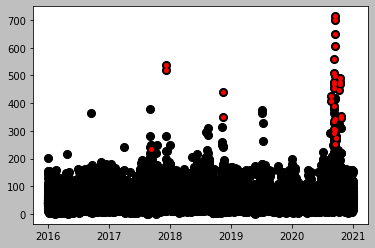

In [221]:
distances = knn_model(data,'PM25_AQI',3)
threshold = 5
plot_outliers(data,'PM25_AQI',2)

# GET OUTLIERS ROWS
pm25_outlier_index = numpy.where(distances.mean(axis = 1) > threshold)
data[data['PM25_AQI'].notnull()].iloc[pm25_outlier_index]

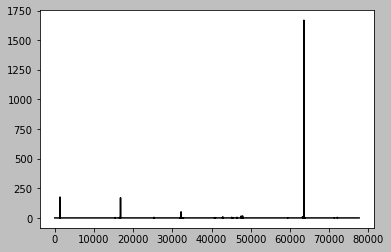

Number of outliers in pollutant PM10_AQI is:13


,State Name,State Code,Date,Sum sites reporting,AQI,Category,OZ_AQI,SO_AQI,NO_AQI,CO_AQI,PM25_AQI,PM10_AQI,Temp,Wind Dir,Wind Speed,Year,Month,Day
1572,California,6,2017-04-06,221,3439,Hazardous,112.0,7.0,56.0,9.0,64.0,3439.0,60.982102,183.990862,5.188498,2017,4,6
1583,California,6,2017-11-09,250,2434,Hazardous,42.0,10.0,35.0,9.0,54.0,2434.0,60.166516,193.060114,4.121047,2017,11,9
20178,California,6,2019-02-26,241,3323,Hazardous,61.0,6.0,50.0,10.0,76.0,3323.0,53.656854,170.217134,5.360763,2019,2,26
20188,California,6,2019-04-30,239,1611,Hazardous,64.0,6.0,50.0,7.0,60.0,1611.0,58.647297,215.943445,5.037609,2019,4,30
20189,California,6,2019-05-15,252,3852,Hazardous,84.0,20.0,34.0,7.0,64.0,3852.0,62.952302,195.575635,6.098623,2019,5,15
38165,California,6,2020-03-14,221,1851,Hazardous,48.0,4.0,42.0,8.0,34.0,1851.0,52.770647,179.966397,6.216144,2020,3,14
74614,California,6,2016-05-19,225,3950,Hazardous,112.0,6.0,38.0,13.0,68.0,3950.0,67.451658,217.801206,5.354413,2016,5,19
74620,California,6,2016-10-15,260,6403,Hazardous,67.0,7.0,36.0,13.0,73.0,6403.0,65.651055,192.095150,5.315292,2016,10,15
74627,California,6,2016-11-19,219,2999,Hazardous,46.0,16.0,48.0,23.0,72.0,2999.0,55.959437,164.357089,4.254303,2016,11,19


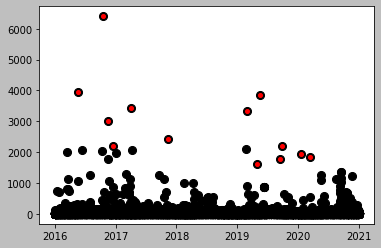

In [222]:
distances = knn_model(data,'PM10_AQI',3)
threshold = 50
plot_outliers(data,'PM10_AQI',30)

# GET OUTLIERS ROWS
pm10_outlier_index = numpy.where(distances.mean(axis = 1) > threshold)
data[data['PM10_AQI'].notnull()].iloc[pm10_outlier_index]

In [223]:
# # ARIMA FOR ANOMALY DETECTION
# time_series_df = data[data['OZ_AQI'].notnull()][['Date','OZ_AQI']]
# time_series_df = time_series_df.sort_values(by="Date")
# # time_series_df = time_series_df.reset_index(drop=True)
# # time_series_df.set_index('Date',inplace=True)

# time_series_df.plot(x='Date',y='OZ_AQI')

# from statsmodels.tsa.stattools import adfuller
# result = adfuller(time_series_df['OZ_AQI'].dropna())
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])

In [224]:
# train = time_series_df[(time_series_df['Date'] <= '2019-12-31')]
# test = time_series_df[(time_series_df['Date'] >= '2020-01-01')]
# plt.plot(train['Date'],train['OZ_AQI'])
# plt.plot(test['Date'],test['OZ_AQI'])

In [225]:
# plot_pacf(time_series_df['OZ_AQI'].dropna());
# plot_pacf(time_series_df['OZ_AQI'].diff().dropna());
# plot_pacf(time_series_df['OZ_AQI'].diff().diff().dropna());

In [226]:
# plot_acf(time_series_df['OZ_AQI'].dropna());
# plot_acf(time_series_df['OZ_AQI'].diff().dropna());
# plot_acf(time_series_df['OZ_AQI'].diff().diff().dropna());

In [227]:
# # order = (p,d,q)
# model = ARIMA(time_series_df['OZ_AQI'], order=(1,0,1))
# model_fit = model.fit()
# squared_errors = model_fit.resid ** 2
# threshold = numpy.mean(squared_errors) + numpy.std(squared_errors)
# predictions = (squared_errors >= threshold).astype(int)
# print('Total outliers:',predictions.sum())
# print(model_fit.aic)

In [228]:
# outlier_index = numpy.where(predictions == 1)
# outlier_values = time_series_df[time_series_df['OZ_AQI'].notnull()].iloc[outlier_index]
# # plot data
# plt.scatter(time_series_df[time_series_df['OZ_AQI'].notnull()]["Date"], time_series_df[time_series_df['OZ_AQI'].notnull()]['OZ_AQI'], color = "black", s = 65)
# # plot outlier values
# plt.scatter(outlier_values["Date"], outlier_values["OZ_AQI"], color = "r")

# len(outlier_values)

In [229]:
# pollutants_list = ['OZ_AQI', 'SO_AQI', 'NO_AQI', 'CO_AQI', 'PM25_AQI','PM10_AQI']
# data[pollutants_list].plot.box(subplots=True, layout=(3,3), figsize=(10, 10))

We tried identifiying univariate outliers with zscore and zscore modified, however the results were not very accurate because our data follows a time series pattern. After doing some research, we found out that the best ways to identify outliers in a time series dataset, is by doing forecasting or an unsupervised clustering model. 

We tried doing ARIMA model, however the local resources were not enough to run the model with a big dataset. Instead of doing forecasting to detect outliers, we decidedes to use an unsupervised technique. For that we used KNN model, we calculated the distances between each observation and plotted them, to determine which threshold filters the anomalities. 

https://towardsdatascience.com/k-nearest-neighbors-knn-for-anomaly-detection-fdf8ee160d13

#### OUTLIERS ANALYSIS CONCLUSION

We have done an univariate analysys per each pollutant. We have found some outliers, however we don't have enough information or the technical knowledge in the field to remove them. We will run the model using outliers data and without outliers data to see if the outliers are having a big influence or not.

# Missing Values

The only variables with missing values are the pollutants, according to the documentation, the reason behind these is because not all states record information for all the pollutants. This mean the missing values are dependant from the states, so that would be Missing at random mechanism (MAR). To prove this, I would use chi contigency analysis to prove the dependancy between the variables.

In [231]:
data.shape

(91851, 18)

In [230]:
for col in data.columns:
    try:
        print(f"Missing values for col {col}: {data[col].isnull().value_counts(dropna=False)[1]} out of {data.shape[0]}.")
    except:
        print(f'No missing values for {col}.')


No missing values for State Name.
No missing values for State Code.
No missing values for Date.
No missing values for Sum sites reporting.
No missing values for AQI.
No missing values for Category.
Missing values for col OZ_AQI: 33 out of 91851.
Missing values for col SO_AQI: 511 out of 91851.
Missing values for col NO_AQI: 4823 out of 91851.
Missing values for col CO_AQI: 717 out of 91851.
Missing values for col PM25_AQI: 1539 out of 91851.
Missing values for col PM10_AQI: 14200 out of 91851.
Missing values for col Temp: 1089 out of 91851.
Missing values for col Wind Dir: 1064 out of 91851.
Missing values for col Wind Speed: 1065 out of 91851.
No missing values for Year.
No missing values for Month.
No missing values for Day.


In [232]:
pollutants_list

['OZ_AQI', 'SO_AQI', 'NO_AQI', 'CO_AQI', 'PM25_AQI', 'PM10_AQI']

In [233]:
for pollutant in pollutants_list:
    if 'PM' in pollutant:
        data.loc[data[pollutant].isnull()==True,pollutant[0:4]+'_missing']='Y'
        data.loc[data[pollutant].isnull()==False,pollutant[0:4]+'_missing']='N'
    else:
        data.loc[data[pollutant].isnull()==True,pollutant[0:2]+'_missing']='Y'
        data.loc[data[pollutant].isnull()==False,pollutant[0:2]+'_missing']='N'

In [234]:
for factor in other_factors:
    if 'Wind' in factor:
        data.loc[data[factor].isnull()==True,factor[0:4]+'_'+factor[5:8]+'_missing']='Y'
        data.loc[data[factor].isnull()==False,factor[0:4]+'_'+factor[5:8]+'_missing']='N'
    else:
        data.loc[data[factor].isnull()==True,factor[0:4]+'_missing']='Y'
        data.loc[data[factor].isnull()==False,factor[0:4]+'_missing']='N'

In [235]:
for col in data.columns:
    try:
        if 'missing' in col:
            missing_val = pd.crosstab(data[data[col]=='Y']['State Name'],
               data[data[col]=='Y'][col])
            not_missing_va = pd.crosstab(data[data[col]=='N']['State Name'],
               data[data[col]=='N'][col])

            contigency_table = pd.merge(missing_val,not_missing_va,on='State Name',how='inner')
            contigency_table = contigency_table.values.tolist()
            chi2, p, dof, ex = chi2_contingency(contigency_table)
            print(f"The p-value for {col} with states list is esqual to {p}")
    except:
        print(f"No missing values in {col}.")
        

The p-value for OZ_missing with states list is esqual to 0.1043413149423491
The p-value for SO_missing with states list is esqual to 5.333886125180136e-258
The p-value for NO_missing with states list is esqual to 0.0
The p-value for CO_missing with states list is esqual to 2.2799341028890997e-174
The p-value for PM25_missing with states list is esqual to 0.0
The p-value for PM10_missing with states list is esqual to 0.0
The p-value for Temp_missing with states list is esqual to 0.0
The p-value for Wind_Dir_missing with states list is esqual to 0.0
The p-value for Wind_Spe_missing with states list is esqual to 0.0


The p value is almost zero, which means there is a dependance between missing values of the pollutants and the states. This confirms what the documentations says, that's why the imputation methods will be assumed that the missing values are MAR missing at random.

# Imputing missing values

In [236]:
data.columns

Index(['State Name', 'State Code', 'Date', 'Sum sites reporting', 'AQI',
       'Category', 'OZ_AQI', 'SO_AQI', 'NO_AQI', 'CO_AQI', 'PM25_AQI',
       'PM10_AQI', 'Temp', 'Wind Dir', 'Wind Speed', 'Year', 'Month', 'Day',
       'OZ_missing', 'SO_missing', 'NO_missing', 'CO_missing', 'PM25_missing',
       'PM10_missing', 'Temp_missing', 'Wind_Dir_missing', 'Wind_Spe_missing'],
      dtype='object')

#### Median Imputation

In [237]:
median_imp_data = data.copy()
median_imp_data.shape

(91851, 27)

In [238]:
missing_index = median_imp_data.loc[median_imp_data['OZ_AQI'].isnull()].index
missing_index

Int64Index([ 4096,  4097,  4098,  4099,  4100,  4101,  4102, 13536, 13537,
            13631, 13698, 13699, 13828, 14490, 14574, 19190, 36979, 36980,
            37211, 37212, 37213, 37285, 37286, 37307, 37308, 37317, 37318,
            49905, 50550, 77168, 77169, 77170, 77182],
           dtype='int64')

In [239]:
imputer = SimpleImputer(missing_values=numpy.nan, strategy='median')

for pollutant in [pollutant for pollutant in pollutants_list if pollutant != 'PM10_AQI']:
    imputer = imputer.fit(median_imp_data[[pollutant]])
    median_imp_data[pollutant] = imputer.transform(median_imp_data[[pollutant]])

In [254]:
median_imp_data = median_imp_data[median_imp_data['State Name'] == 'California'].reset_index(drop=True)
median_imp_data[['State Name', 'State Code', 'Date', 'Sum sites reporting', 'AQI',
       'Category', 'OZ_AQI', 'SO_AQI', 'NO_AQI', 'CO_AQI', 'PM25_AQI',
       'PM10_AQI', 'Temp', 'Wind Dir', 'Wind Speed', 'Year', 'Month', 'Day']]\
.to_csv('data/FinalData/FinalData_median-imputed.csv',index=False)


#### Regression Imputation

In [241]:
# Did not work because there is no relation between pollutants.
corr = data[['OZ_AQI', 'SO_AQI', 'NO_AQI', 'CO_AQI', 'PM25_AQI',
       'PM10_AQI', 'Temp', 'Wind Dir', 'Wind Speed','AQI']].corr()
corr.style.background_gradient(cmap='coolwarm')


,OZ_AQI,SO_AQI,NO_AQI,CO_AQI,PM25_AQI,PM10_AQI,Temp,Wind Dir,Wind Speed,AQI
OZ_AQI,1.000000,0.052037,0.319043,0.087897,0.264651,0.176288,0.414542,0.019673,-0.038891,0.358237
SO_AQI,0.052037,1.000000,0.115829,0.139669,0.125158,0.025116,0.076818,-0.141698,0.049200,0.268970
NO_AQI,0.319043,0.115829,1.000000,0.489270,0.344785,0.159133,-0.072993,0.040527,-0.082390,0.203896
CO_AQI,0.087897,0.139669,0.489270,1.000000,0.427752,0.145364,-0.000811,-0.086803,-0.110784,0.202463
PM25_AQI,0.264651,0.125158,0.344785,0.427752,1.000000,0.263068,0.041218,-0.078796,-0.105954,0.430160
PM10_AQI,0.176288,0.025116,0.159133,0.145364,0.263068,1.000000,0.073157,0.010559,0.019715,0.888670
Temp,0.414542,0.076818,-0.072993,-0.000811,0.041218,0.073157,1.000000,-0.168326,-0.105666,0.115079
Wind Dir,0.019673,-0.141698,0.040527,-0.086803,-0.078796,0.010559,-0.168326,1.000000,0.077603,-0.043793
Wind Speed,-0.038891,0.049200,-0.082390,-0.110784,-0.105954,0.019715,-0.105666,0.077603,1.000000,-0.013333
AQI,0.358237,0.268970,0.203896,0.202463,0.430160,0.888670,0.115079,-0.043793,-0.013333,1.000000


We don't have any big relation between the numerical variable with missing values 

#### KNN Imputation

In [242]:
knn_imp_data = data.copy()
knn_imp_data.shape

(91851, 27)

In [243]:
# First I will impute each column, where there are missing values and the rest of the column doesn't have missing values
# with the purpose of balancing and having all columns with the same number of missing data
knn = KNeighborsClassifier(3,weights='distance')

for pollutant in [pollutant for pollutant in pollutants_list if pollutant != 'PM10_AQI']:
    print(pollutant)
    without_nulls = knn_imp_data.loc[:,pollutants_list].dropna()
    nulls = knn_imp_data.loc[knn_imp_data[pollutant].isnull(),\
                             [pol for pol in pollutants_list if pol != pollutant] ].dropna()
    model_knn = knn.fit(without_nulls[[pol for pol in pollutants_list if pol != pollutant]],
                   without_nulls[[pollutant]])
    
    imputed_values = model_knn.predict(nulls[[pol for pol in pollutants_list if pol != pollutant]])
    knn_imp_data.loc[nulls.index,pollutant] = imputed_values
    print(f"Number of missing values filled: {nulls.shape[0]}. ")

OZ_AQI
Number of missing values filled: 18. 
SO_AQI
Number of missing values filled: 453. 
NO_AQI
Number of missing values filled: 4659. 
CO_AQI
Number of missing values filled: 585. 
PM25_AQI
Number of missing values filled: 897. 


In [244]:
for pollutant in pollutants_list:
    print(pollutant)
    print(knn_imp_data.loc[knn_imp_data[pollutant].isnull(),
                [pol for pol in pollutants_list if pol != pollutant] ].isnull().value_counts())

OZ_AQI
SO_AQI  NO_AQI  CO_AQI  PM25_AQI  PM10_AQI
False   True    False   False     False       12
        False   False   False     True         3
dtype: int64
SO_AQI
OZ_AQI  NO_AQI  CO_AQI  PM25_AQI  PM10_AQI
False   False   False   True      False       22
                        False     True        17
        True    False   False     False       11
        False   False   True      True         8
dtype: int64
NO_AQI
OZ_AQI  SO_AQI  CO_AQI  PM25_AQI  PM10_AQI
False   False   False   False     True        141
True    False   False   False     False        12
False   True    False   False     False        11
dtype: int64
CO_AQI
OZ_AQI  SO_AQI  NO_AQI  PM25_AQI  PM10_AQI
False   False   False   False     True        90
                        True      False       42
dtype: int64
PM25_AQI
OZ_AQI  SO_AQI  NO_AQI  CO_AQI  PM10_AQI
False   False   False   False   True        570
                        True    False        42
        True    False   False   False        22
            

In [245]:
# Now I will go in detail checking by each pollutan which information can I use to predict the values that are missing
# OZ_AQI
pollutant = 'OZ_AQI'
print(knn_imp_data.loc[knn_imp_data[pollutant].isnull(),
                [pol for pol in pollutants_list if pol != pollutant] ].isnull().value_counts())

without_nulls = knn_imp_data.loc[:,pollutants_list].dropna()
nulls = knn_imp_data.loc[knn_imp_data[pollutant].isnull(),\
                         [pol for pol in pollutants_list if pol not in [pollutant,'NO_AQI']] ].dropna()
model_knn = knn.fit(without_nulls[[pol for pol in pollutants_list if pol not in [pollutant,'NO_AQI']] ],
               without_nulls[[pollutant]])

imputed_values = model_knn.predict(nulls[[pol for pol in pollutants_list if pol not in [pollutant,'NO_AQI']] ])
knn_imp_data.loc[nulls.index,pollutant] = imputed_values
print(f"Number of missing values filled: {nulls.shape[0]}. ")

SO_AQI  NO_AQI  CO_AQI  PM25_AQI  PM10_AQI
False   True    False   False     False       12
        False   False   False     True         3
dtype: int64
Number of missing values filled: 12. 


In [246]:
# Now I will go in detail checking by each pollutan which information can I use to predict the values that are missing
# SO_AQI
pollutant = 'SO_AQI'
print(knn_imp_data.loc[knn_imp_data[pollutant].isnull(),
                [pol for pol in pollutants_list if pol != pollutant] ].isnull().value_counts())

without_nulls = knn_imp_data.loc[:,pollutants_list].dropna()
nulls = knn_imp_data.loc[knn_imp_data[pollutant].isnull(),\
                         [pol for pol in pollutants_list if pol not in [pollutant,'NO_AQI']] ].dropna()
model_knn = knn.fit(without_nulls[[pol for pol in pollutants_list if pol not in [pollutant,'NO_AQI']] ],
               without_nulls[[pollutant]])

imputed_values = model_knn.predict(nulls[[pol for pol in pollutants_list if pol not in [pollutant,'NO_AQI']] ])
knn_imp_data.loc[nulls.index,pollutant] = imputed_values
print(f"Number of missing values filled: {nulls.shape[0]}. ")

OZ_AQI  NO_AQI  CO_AQI  PM25_AQI  PM10_AQI
False   False   False   True      False       22
                        False     True        17
        True    False   False     False       11
        False   False   True      True         8
dtype: int64
Number of missing values filled: 11. 


In [247]:
# NO_AQI
pollutant = 'NO_AQI'
print(knn_imp_data.loc[knn_imp_data[pollutant].isnull(),
                [pol for pol in pollutants_list if pol != pollutant] ].isnull().value_counts())

without_nulls = knn_imp_data.loc[:,pollutants_list].dropna()
nulls = knn_imp_data.loc[knn_imp_data[pollutant].isnull(),\
                         [pol for pol in pollutants_list if pol not in [pollutant,'PM25_AQI']] ].dropna()
model_knn = knn.fit(without_nulls[[pol for pol in pollutants_list if pol not in [pollutant,'PM25_AQI']] ],
               without_nulls[[pollutant]])

imputed_values = model_knn.predict(nulls[[pol for pol in pollutants_list if pol not in [pollutant,'PM25_AQI']] ])
knn_imp_data.loc[nulls.index,pollutant] = imputed_values
print(f"Number of missing values filled: {nulls.shape[0]}. ")

OZ_AQI  SO_AQI  CO_AQI  PM25_AQI  PM10_AQI
False   False   False   False     True        141
                                  False        23
dtype: int64
Number of missing values filled: 23. 


In [248]:
knn_imp_data.columns

Index(['State Name', 'State Code', 'Date', 'Sum sites reporting', 'AQI',
       'Category', 'OZ_AQI', 'SO_AQI', 'NO_AQI', 'CO_AQI', 'PM25_AQI',
       'PM10_AQI', 'Temp', 'Wind Dir', 'Wind Speed', 'Year', 'Month', 'Day',
       'OZ_missing', 'SO_missing', 'NO_missing', 'CO_missing', 'PM25_missing',
       'PM10_missing', 'Temp_missing', 'Wind_Dir_missing', 'Wind_Spe_missing'],
      dtype='object')

In [255]:
knn_imp_data = knn_imp_data[knn_imp_data['State Name'] == 'California'].reset_index(drop=True)
knn_imp_data[['State Name', 'State Code', 'Date', 'Sum sites reporting', 'AQI',
       'Category', 'OZ_AQI', 'SO_AQI', 'NO_AQI', 'CO_AQI', 'PM25_AQI',
       'PM10_AQI', 'Temp', 'Wind Dir', 'Wind Speed', 'Year', 'Month', 'Day']]\
.to_csv('data/FinalData/FinalData_knn-imputed.csv',index=False)


In [250]:
df = knn_imp_data[(knn_imp_data['State Name'] == 'California')& ((knn_imp_data['Year'] >= 2020))].reset_index(drop=True)

<AxesSubplot:xlabel='Date'>

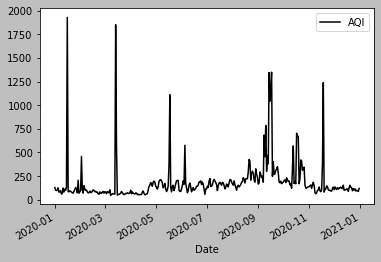

In [251]:
df.plot.line(x='Date',y=['AQI'])

In [252]:
data[data['State Name'] == 'California'].shape

(1827, 27)

In [253]:
knn_imp_data['State Name'].value_counts()

Alabama                 1827
Minnesota               1827
Alaska                  1827
Nevada                  1827
New Hampshire           1827
New Mexico              1827
New York                1827
North Carolina          1827
Ohio                    1827
Oklahoma                1827
Pennsylvania            1827
Rhode Island            1827
South Carolina          1827
South Dakota            1827
Tennessee               1827
Texas                   1827
Utah                    1827
Virginia                1827
Washington              1827
Wisconsin               1827
Wyoming                 1827
Missouri                1827
Montana                 1827
Michigan                1827
Colorado                1827
California              1827
District Of Columbia    1827
Florida                 1827
Georgia                 1827
Hawaii                  1827
Idaho                   1827
Illinois                1827
Indiana                 1827
Connecticut             1827
Iowa          